In [2]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import os
import numpy as np

from train_prob_unet_model import get_args
from prob_unet import ProbabilisticUNet
import climex_utils as cu


args = get_args()
args.lowres_scale = 16
args.batch_size = 32


dataset_test = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_test,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_residuals",
    transfo=True
)

# 4) Create the test DataLoader
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=0
)

probunet_model = ProbabilisticUNet(
    input_channels=len(args.variables),
    num_classes=len(args.variables),
    latent_dim=16,            
    num_filters=[32, 64, 128, 256],
    model_channels=32,
    channel_mult=[1, 2, 4, 8],
    beta_0=0.0,
    beta_1=0.0,
    beta_2=0.0
).to(args.device)


model_path = "./results/plots/04/04/202510:11:03/probunet_model_lat_dim_16.pth"
if not os.path.isfile(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

state_dict = torch.load(model_path, map_location=args.device)
probunet_model.load_state_dict(state_dict)
probunet_model.eval()

print("Model loaded successfully!")

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Model loaded successfully!


In [3]:
def invert_transfo_3vars(data_3ch: torch.Tensor) -> torch.Tensor:
    """
    data_3ch shape: [*, 3, H, W] in the same 'transfo' domain as stored in dataset.
    Returns the real-domain [*, 3, H, W] in mm/day (for pr) and °C (for tasmin, tasmax).
    """
    # Imports from climex_utils
    from climex_utils import softplus, kgm2sTommday, KToC

    # Ensure we work in float
    data_3ch = data_3ch.float()

    # Split the three variables
    pr_stored    = data_3ch[:, 0, ...]  # shape [* , H, W]
    tasmin_stored= data_3ch[:, 1, ...]
    tasmax_stored= data_3ch[:, 2, ...]

    # 1) Precip => pr_real in mm/day
    pr_real = kgm2sTommday( softplus(pr_stored) )

    # 2) tasmin => in Kelvin originally, so we just do KToC
    tasmin_real = KToC(tasmin_stored)

    # 3) tasmax => we stored softplus_inv(tasmax - tasmin). 
    #    Invert => tasmax = softplus(tasmax_stored) + tasmin_stored
    #    Then convert from K to °C
    tasmax_real = KToC( softplus(tasmax_stored) + tasmin_stored )

    # Re-stack
    return torch.stack([pr_real, tasmin_real, tasmax_real], dim=1)

In [4]:
num_samples = 15  
all_preds_transformed = []
all_hr_transformed = []

with torch.no_grad():
    for batch in dataloader_test:
        inputs = batch['inputs'].to(args.device)      # [B, 3, H, W] in transfo domain
        hr_trans = batch['hr'].to(args.device)        # [B, 3, H, W] in transfo domain
        lrinterp = batch['lrinterp'].to(args.device)  # [B, 3, H, W] in real domain? Actually it's in the original domain if "transfo" was applied. But we only need it to reconstruct.
        timestamps = batch['timestamps'].unsqueeze(1).to(args.device)

        # Generate an ensemble of predictions
        ensemble_preds_trans = []
        for _ in range(num_samples):
            out_residual = probunet_model(inputs, target=None, t=timestamps, training=False)
            # Reconstruct to "transfo" domain of HR:
            out_hr_trans = dataloader_test.dataset.residual_to_hr(out_residual.cpu(), lrinterp.cpu())
            # shape: (B, 3, H, W)
            ensemble_preds_trans.append(out_hr_trans.numpy())

        ensemble_preds_trans = np.stack(ensemble_preds_trans, axis=1)  # (B, num_samples, 3, H, W)

        all_hr_transformed.append(hr_trans.cpu().numpy())             
        all_preds_transformed.append(ensemble_preds_trans)

# Concatenate over batch => shape (T, 3, H, W) and (T, num_samples, 3, H, W)
all_hr_transformed = np.concatenate(all_hr_transformed, axis=0)
all_preds_transformed = np.concatenate(all_preds_transformed, axis=0)

Computing statistics for standardization


In [5]:
# We'll convert everything into Torch Tensors, pass them through `invert_transfo_3vars`,
# and then convert back to NumPy if needed for CRPS, etc.

all_hr_trans_torch = torch.from_numpy(all_hr_transformed)               # [T, 3, H, W]
all_preds_trans_torch = torch.from_numpy(all_preds_transformed)         # [T, num_samples, 3, H, W]

# We'll create arrays to store real-domain data
# shape (T, 3, H, W) in real units
all_hr_real_list = []
all_preds_real_list = []

# Process in chunks if memory is an issue, or all at once if not
T = all_hr_trans_torch.shape[0]
for i in range(T):
    # Single sample: shape [3, H, W]
    hr_i = all_hr_trans_torch[i].unsqueeze(0)  # [1, 3, H, W]
    hr_i_real = invert_transfo_3vars(hr_i)     # => [1, 3, H, W]

    # For predictions: shape [num_samples, 3, H, W]
    preds_i = all_preds_trans_torch[i]         # [num_samples, 3, H, W]
    preds_i_real_list = []
    for m in range(preds_i.shape[0]):
        pred_im = preds_i[m].unsqueeze(0)      # [1, 3, H, W]
        pred_im_real = invert_transfo_3vars(pred_im)  # => [1, 3, H, W]
        preds_i_real_list.append(pred_im_real.squeeze(0))  # => [3, H, W]

    # Combine predictions for sample i => [num_samples, 3, H, W]
    preds_i_real = torch.stack(preds_i_real_list, dim=0)

    all_hr_real_list.append(hr_i_real.squeeze(0))  # => [3, H, W]
    all_preds_real_list.append(preds_i_real)       # => [num_samples, 3, H, W]

# Now stack everything:
#   all_hr_real => shape [T, 3, H, W] in real domain
#   all_preds_real => shape [T, num_samples, 3, H, W] in real domain
all_hr_real = torch.stack(all_hr_real_list, dim=0)
all_preds_real = torch.stack(all_preds_real_list, dim=0)

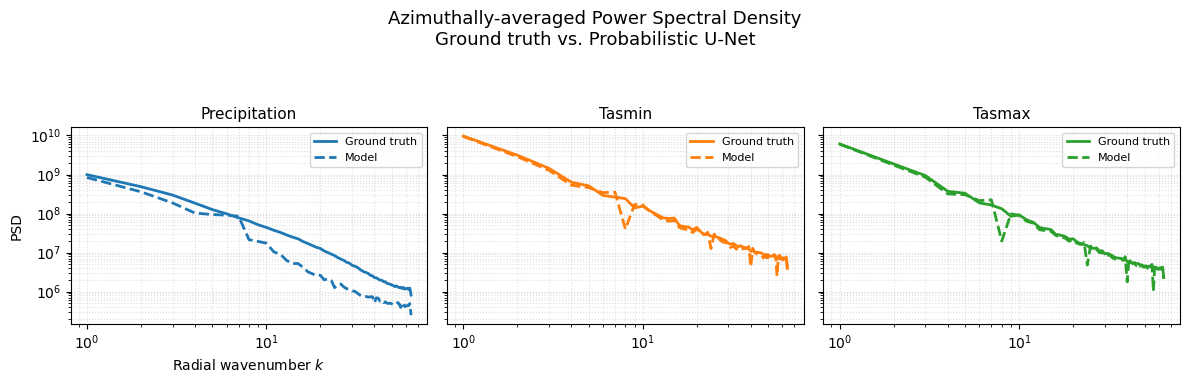

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats
import climex_utils as cu        
plt.rcParams["figure.figsize"] = (6,4)

# ------------------------------------------------------------
# 2) Low-level PSD of a single 2-D field
# ------------------------------------------------------------
def psd(image2d: torch.Tensor):
    """
    Compute azimuthally-averaged 2-D power spectral density.

    image2d : torch.Tensor [H,W]  (real domain; NOT batched)
    Returns  : k (spatial wavenumber)  and  P(k)
    """
    H, W = image2d.shape
    fourier = torch.fft.fftn(image2d)
    power   = torch.abs(fourier) ** 2         # |F(k)|²

    # Radial frequency grid
    kfreq = torch.fft.fftfreq(H) * H
    kx, ky = torch.meshgrid(kfreq, kfreq, indexing='ij')
    kr     = torch.sqrt(kx**2 + ky**2).flatten().cpu().numpy()
    powerf = power.flatten().cpu().numpy()

    kbins = np.arange(0.5, H//2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    psd_vals, _, _ = stats.binned_statistic(
        kr, powerf, statistic="mean", bins=kbins
    )
    psd_vals *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)   # 2-D shell area
    return kvals, psd_vals

# ------------------------------------------------------------
# 3) PSD over a 4-D or 5-D tensor
#    hr            : [T, 3, H, W]
#    preds         : [T, M, 3, H, W]   (optional ensemble dim)
#    transfo == True  →  data still in stored-transform space
# ------------------------------------------------------------
def compute_psd_tensor(data: torch.Tensor, transfo: bool):
    """
    Returns dict {'pr': P(k), 'tasmin': P(k), 'tasmax': P(k)}
    averaged over all time steps (and ensemble members if present).
    """
    # bring to (N, 3, H, W) where N = T  or  (T*M)
    if data.dim() == 5:                                 # predictions
        T, M, C, H, W = data.shape
        data_use = data.reshape(T*M, C, H, W)
    else:                                               # ground truth
        data_use = data

    psd_acc = {'pr': [], 'tasmin': [], 'tasmax': []}

    for sample in data_use:            # iterate over N samples
        # undo transforms if needed
        s = sample.clone()
        if transfo:
            s[0] = cu.softplus(s[0])                                   # pr
            s[2] = cu.softplus(s[2], c=0) + s[1]                       # tasmax

        # now convert to real units
        s[0] = cu.kgm2sTommday(s[0])
        s[1] = cu.KToC(s[1])
        s[2] = cu.KToC(s[2])

        for idx, key in enumerate(['pr', 'tasmin', 'tasmax']):
            _, p = psd(s[idx])
            psd_acc[key].append(p)

    # mean over samples → array length ~H/2 for every var
    return {k: np.mean(np.stack(v, axis=0), axis=0) for k, v in psd_acc.items()}

# ------------------------------------------------------------
# 4) Compute PSDs
# ------------------------------------------------------------
psd_gt   = compute_psd_tensor(all_hr_trans_torch,     transfo=True)
psd_pred = compute_psd_tensor(all_preds_trans_torch,  transfo=True)

# common radial wavenumber axis (same for every call to psd)
kvals, _ = psd(all_hr_trans_torch[0,0])

# ------------------------------------------------------------
# 5) Plot
# ------------------------------------------------------------
var_names  = ['pr', 'tasmin', 'tasmax']
long_names = ['Precipitation', 'Tasmin', 'Tasmax']
units      = ['mm day⁻¹', '°C', '°C']
colors     = ['tab:blue', 'tab:orange', 'tab:green']

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True, sharey=True)

for ax, v, vlong, u, c in zip(axes, var_names, long_names, units, colors):
    ax.loglog(kvals, psd_gt[v],   color=c, lw=2, label='Ground truth')
    ax.loglog(kvals, psd_pred[v], color=c, ls='--', lw=2, label='Model')

    ax.set_title(vlong, fontsize=11)
    ax.grid(True, which='both', ls=':', alpha=0.4)
    ax.legend(fontsize=8, loc='upper right')

axes[0].set_xlabel('Radial wavenumber $k$')
axes[0].set_ylabel('PSD')
plt.suptitle('Azimuthally-averaged Power Spectral Density\nGround truth vs. Probabilistic U-Net', y=1.08, fontsize=13)
plt.tight_layout()
# plt.savefig('psd_comparison_3panel.png', dpi=300)
plt.show()


In [7]:
from metrics import crps_over_groundtruth
# The crps_over_groundtruth function expects
#   hr shape => (T, 3, H, W)
#   preds shape => (T, num_samples, 3, H, W)
# in torch.Tensor. Perfect.
crps_dict = crps_over_groundtruth(all_hr_real, all_preds_real)
print("== CRPS Results in REAL Domain ==")
for var in crps_dict:
    print(f"{var}: {crps_dict[var]:.4f}")

Pysteps configuration file found at: /home/maalih@labos.polymtl.ca/anaconda3/envs/diffusion/lib/python3.12/site-packages/pysteps/pystepsrc

== CRPS Results in REAL Domain ==
pr: 1.2132
tasmin: 1.2652
tasmax: 0.9349


In [10]:
# Average MAE: We compute the average over the ensemble dimension first, and then compute the MAE.
# 1) Compute the average prediction across the ensemble dimension
all_preds_avg = all_preds_real.mean(axis=1)  # shape (T, 3, H, W)

# 2) Compute the absolute difference between average predictions and ground truth
abs_diff = np.abs(all_preds_avg.numpy() - all_hr_real.numpy())  # shape (T, 3, H, W)

# 3) Compute MAE: Mean over all time steps (T), height (H), and width (W)
mae_per_var = abs_diff.mean(axis=(0, 2, 3))  # shape (3,) for 3 variables

# 4) Output MAE per variable
print("\n== Average MAE per Variable in REAL Domain (Average over ensemble first) ==")
print(f"pr:     {mae_per_var[0]:.4f} mm/day")
print(f"tasmin: {mae_per_var[1]:.4f} °C")
print(f"tasmax: {mae_per_var[2]:.4f} °C")


== Average MAE per Variable in REAL Domain (Average over ensemble first) ==
pr:     1.5027 mm/day
tasmin: 1.5347 °C
tasmax: 1.1953 °C


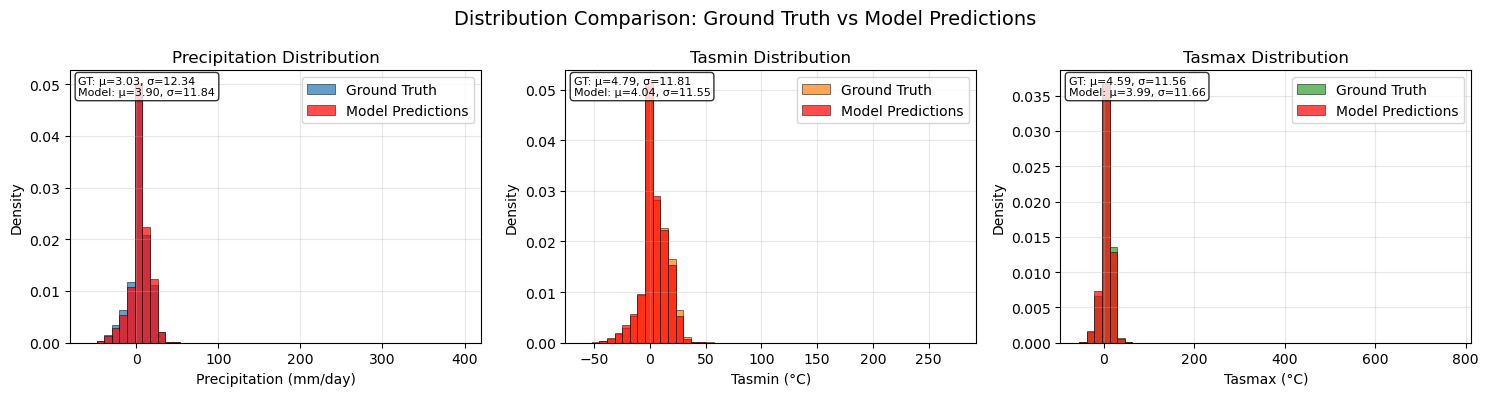

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution_comparison(hr_real, preds_real, num_bins=50):
    """
    Plot histogram distributions comparing ground truth vs model predictions
    
    Args:
        hr_real: torch.Tensor shape [T, 3, H, W] - ground truth in real domain
        preds_real: torch.Tensor shape [T, num_samples, 3, H, W] - predictions in real domain
        num_bins: number of histogram bins
    """
    # Convert to numpy and flatten spatial dimensions
    hr_np = hr_real.numpy()  # [T, 3, H, W]
    preds_np = preds_real.numpy()  # [T, num_samples, 3, H, W]
    
    # Flatten to get all values for each variable
    hr_flat = hr_np.reshape(hr_np.shape[0], 3, -1)  # [T, 3, H*W]
    preds_flat = preds_np.reshape(preds_np.shape[0], preds_np.shape[1], 3, -1)  # [T, num_samples, 3, H*W]
    
    # Further flatten to get all values across time and space
    hr_all = hr_flat.reshape(3, -1)  # [3, T*H*W]
    preds_all = preds_flat.reshape(preds_flat.shape[1], 3, -1)  # [num_samples, 3, T*H*W]
    
    var_names = ['Precipitation', 'Tasmin', 'Tasmax']
    units = ['mm/day', '°C', '°C']
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, (ax, var_name, unit, color) in enumerate(zip(axes, var_names, units, colors)):
        # Ground truth data for variable i
        gt_data = hr_all[i]
        
        # Model predictions for variable i (average across ensemble members)
        pred_data_all_members = preds_all[:, i, :].flatten()  # All ensemble members flattened
        
        # Create histogram bins based on the range of both datasets
        data_min = min(gt_data.min(), pred_data_all_members.min())
        data_max = max(gt_data.max(), pred_data_all_members.max())
        bins = np.linspace(data_min, data_max, num_bins)
        
        # Plot histograms
        ax.hist(gt_data, bins=bins, alpha=0.7, density=True, 
                label='Ground Truth', color=color, edgecolor='black', linewidth=0.5)
        ax.hist(pred_data_all_members, bins=bins, alpha=0.7, density=True, 
                label='Model Predictions', color='red', edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel(f'{var_name} ({unit})')
        ax.set_ylabel('Density')
        ax.set_title(f'{var_name} Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        gt_mean, gt_std = gt_data.mean(), gt_data.std()
        pred_mean, pred_std = pred_data_all_members.mean(), pred_data_all_members.std()
        
        stats_text = f'GT: μ={gt_mean:.2f}, σ={gt_std:.2f}\nModel: μ={pred_mean:.2f}, σ={pred_std:.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=8, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Distribution Comparison: Ground Truth vs Model Predictions', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot the distributions
plot_distribution_comparison(all_hr_real, all_preds_real)

Plotting frequency distributions...


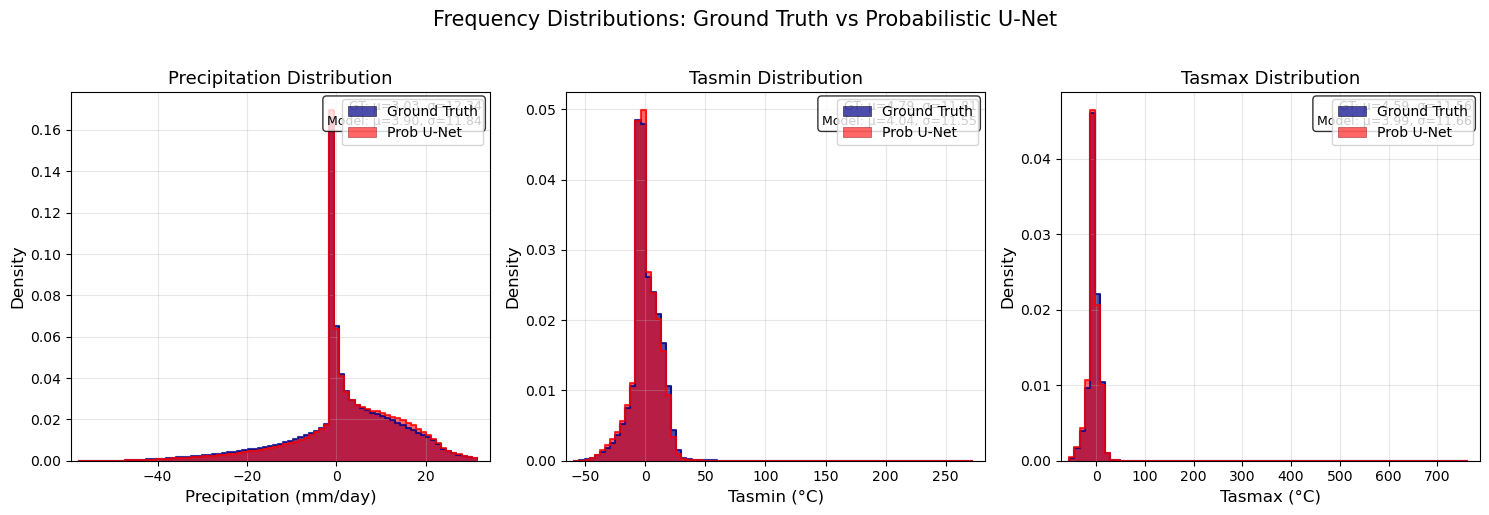

Plotting frequency distributions with log scale for precipitation...


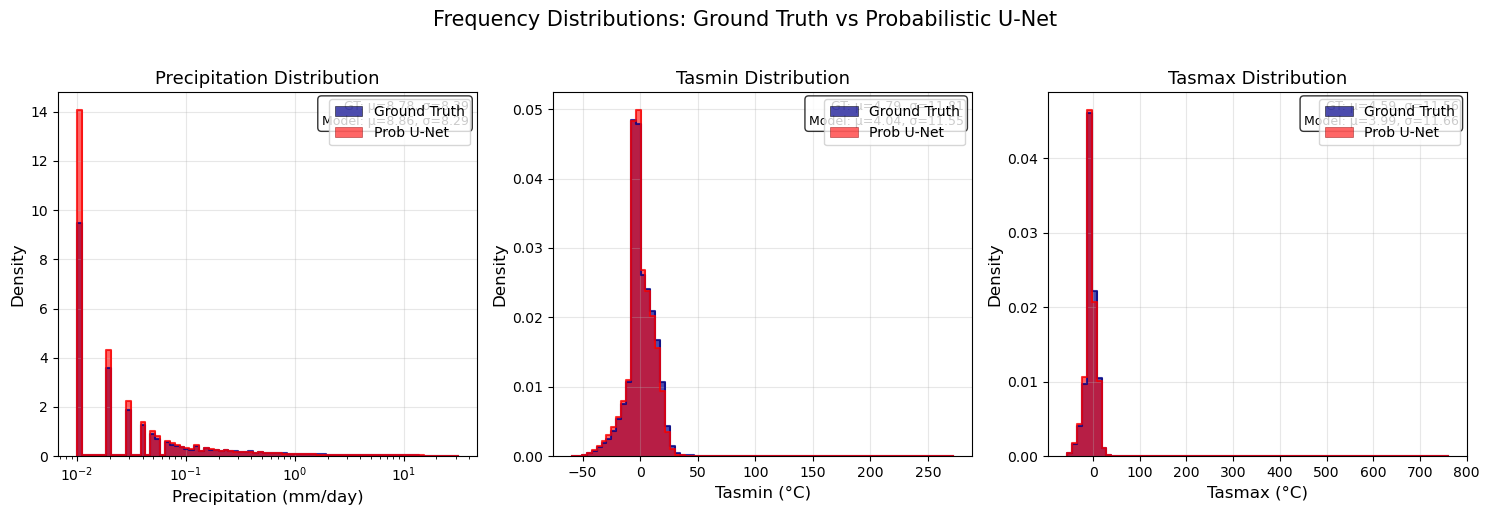

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_frequency_distributions(hr_real, preds_real, num_bins=100):
    """
    Plot frequency distribution histograms comparing ground truth vs model predictions
    in the style of the reference image
    
    Args:
        hr_real: torch.Tensor shape [T, 3, H, W] - ground truth in real domain
        preds_real: torch.Tensor shape [T, num_samples, 3, H, W] - predictions in real domain
        num_bins: number of histogram bins
    """
    # Convert to numpy and flatten spatial dimensions
    hr_np = hr_real.numpy()  # [T, 3, H, W]
    preds_np = preds_real.numpy()  # [T, num_samples, 3, H, W]
    
    # Flatten to get all values for each variable
    hr_flat = hr_np.reshape(hr_np.shape[0], 3, -1)  # [T, 3, H*W]
    preds_flat = preds_np.reshape(preds_np.shape[0], preds_np.shape[1], 3, -1)  # [T, num_samples, 3, H*W]
    
    # Further flatten to get all values across time and space
    hr_all = hr_flat.reshape(3, -1)  # [3, T*H*W]
    preds_all = preds_flat.reshape(preds_flat.shape[1], 3, -1)  # [num_samples, 3, T*H*W]
    
    var_names = ['Precipitation', 'Tasmin', 'Tasmax']
    units = ['mm/day', '°C', '°C']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (ax, var_name, unit) in enumerate(zip(axes, var_names, units)):
        # Ground truth data for variable i
        gt_data = hr_all[i]
        
        # Model predictions for variable i (all ensemble members)
        pred_data_all_members = preds_all[:, i, :].flatten()
        
        # Create histogram bins based on the range of both datasets
        data_min = min(gt_data.min(), pred_data_all_members.min())
        data_max = max(gt_data.max(), pred_data_all_members.max())
        
        # For precipitation, might want to focus on reasonable range
        if i == 0:  # precipitation
            data_max = min(data_max, np.percentile(gt_data, 99.5))  # Cap at 99.5th percentile
        
        bins = np.linspace(data_min, data_max, num_bins)
        
        # Compute histograms
        gt_counts, gt_bin_edges = np.histogram(gt_data, bins=bins, density=True)
        pred_counts, pred_bin_edges = np.histogram(pred_data_all_members, bins=bins, density=True)
        
        # Plot filled histograms with step style
        ax.fill_between(gt_bin_edges[:-1], 0, gt_counts, 
                       step='pre', alpha=0.7, color='darkblue', 
                       label='Ground Truth', edgecolor='black', linewidth=0.5)
        
        ax.fill_between(pred_bin_edges[:-1], 0, pred_counts, 
                       step='pre', alpha=0.6, color='red', 
                       label='Prob U-Net', edgecolor='darkred', linewidth=0.5)
        
        # Also plot the step outline for clarity
        ax.step(gt_bin_edges[:-1], gt_counts, where='pre', 
                color='darkblue', linewidth=1.5, alpha=0.8)
        ax.step(pred_bin_edges[:-1], pred_counts, where='pre', 
                color='red', linewidth=1.5, alpha=0.8)
        
        ax.set_xlabel(f'{var_name} ({unit})', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title(f'{var_name} Distribution', fontsize=13)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Set y-axis to start from 0
        ax.set_ylim(bottom=0)
        
        # Add some padding to x-axis
        x_range = data_max - data_min
        ax.set_xlim(data_min - 0.02*x_range, data_max + 0.02*x_range)
        
        # Add statistics in a box
        gt_mean, gt_std = gt_data.mean(), gt_data.std()
        pred_mean, pred_std = pred_data_all_members.mean(), pred_data_all_members.std()
        
        stats_text = f'GT: μ={gt_mean:.2f}, σ={gt_std:.2f}\nModel: μ={pred_mean:.2f}, σ={pred_std:.2f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.suptitle('Frequency Distributions: Ground Truth vs Probabilistic U-Net', fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()

# Alternative version with log scale for precipitation (if needed)
def plot_frequency_distributions_log_precip(hr_real, preds_real, num_bins=100):
    """
    Same as above but with log scale for precipitation to better show the distribution
    """
    # Convert to numpy and flatten spatial dimensions
    hr_np = hr_real.numpy()
    preds_np = preds_real.numpy()
    
    hr_flat = hr_np.reshape(hr_np.shape[0], 3, -1)
    preds_flat = preds_np.reshape(preds_np.shape[0], preds_np.shape[1], 3, -1)
    
    hr_all = hr_flat.reshape(3, -1)
    preds_all = preds_flat.reshape(preds_flat.shape[1], 3, -1)
    
    var_names = ['Precipitation', 'Tasmin', 'Tasmax']
    units = ['mm/day', '°C', '°C']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (ax, var_name, unit) in enumerate(zip(axes, var_names, units)):
        gt_data = hr_all[i]
        pred_data_all_members = preds_all[:, i, :].flatten()
        
        if i == 0:  # Precipitation - use log scale
            # Remove zeros and negative values for log scale
            gt_data_pos = gt_data[gt_data > 0.01]
            pred_data_pos = pred_data_all_members[pred_data_all_members > 0.01]
            
            # Log-spaced bins
            data_min = min(gt_data_pos.min(), pred_data_pos.min())
            data_max = min(max(gt_data_pos.max(), pred_data_pos.max()), 
                          np.percentile(gt_data_pos, 99.5))
            
            bins = np.logspace(np.log10(data_min), np.log10(data_max), num_bins)
            ax.set_xscale('log')
            
            gt_data_use = gt_data_pos
            pred_data_use = pred_data_pos
        else:
            # Linear scale for temperature
            data_min = min(gt_data.min(), pred_data_all_members.min())
            data_max = max(gt_data.max(), pred_data_all_members.max())
            bins = np.linspace(data_min, data_max, num_bins)
            
            gt_data_use = gt_data
            pred_data_use = pred_data_all_members
        
        # Compute histograms
        gt_counts, gt_bin_edges = np.histogram(gt_data_use, bins=bins, density=True)
        pred_counts, pred_bin_edges = np.histogram(pred_data_use, bins=bins, density=True)
        
        # Plot filled histograms
        ax.fill_between(gt_bin_edges[:-1], 0, gt_counts, 
                       step='pre', alpha=0.7, color='darkblue', 
                       label='Ground Truth', edgecolor='black', linewidth=0.5)
        
        ax.fill_between(pred_bin_edges[:-1], 0, pred_counts, 
                       step='pre', alpha=0.6, color='red', 
                       label='Prob U-Net', edgecolor='darkred', linewidth=0.5)
        
        ax.step(gt_bin_edges[:-1], gt_counts, where='pre', 
                color='darkblue', linewidth=1.5, alpha=0.8)
        ax.step(pred_bin_edges[:-1], pred_counts, where='pre', 
                color='red', linewidth=1.5, alpha=0.8)
        
        ax.set_xlabel(f'{var_name} ({unit})', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title(f'{var_name} Distribution', fontsize=13)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
        
        # Statistics
        gt_mean, gt_std = gt_data_use.mean(), gt_data_use.std()
        pred_mean, pred_std = pred_data_use.mean(), pred_data_use.std()
        
        stats_text = f'GT: μ={gt_mean:.2f}, σ={gt_std:.2f}\nModel: μ={pred_mean:.2f}, σ={pred_std:.2f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.suptitle('Frequency Distributions: Ground Truth vs Probabilistic U-Net', fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot the distributions
print("Plotting frequency distributions...")
plot_frequency_distributions(all_hr_real, all_preds_real, num_bins=80)

# Alternative with log scale for precipitation
print("Plotting frequency distributions with log scale for precipitation...")
plot_frequency_distributions_log_precip(all_hr_real, all_preds_real, num_bins=80)

Plotting log-frequency distributions...


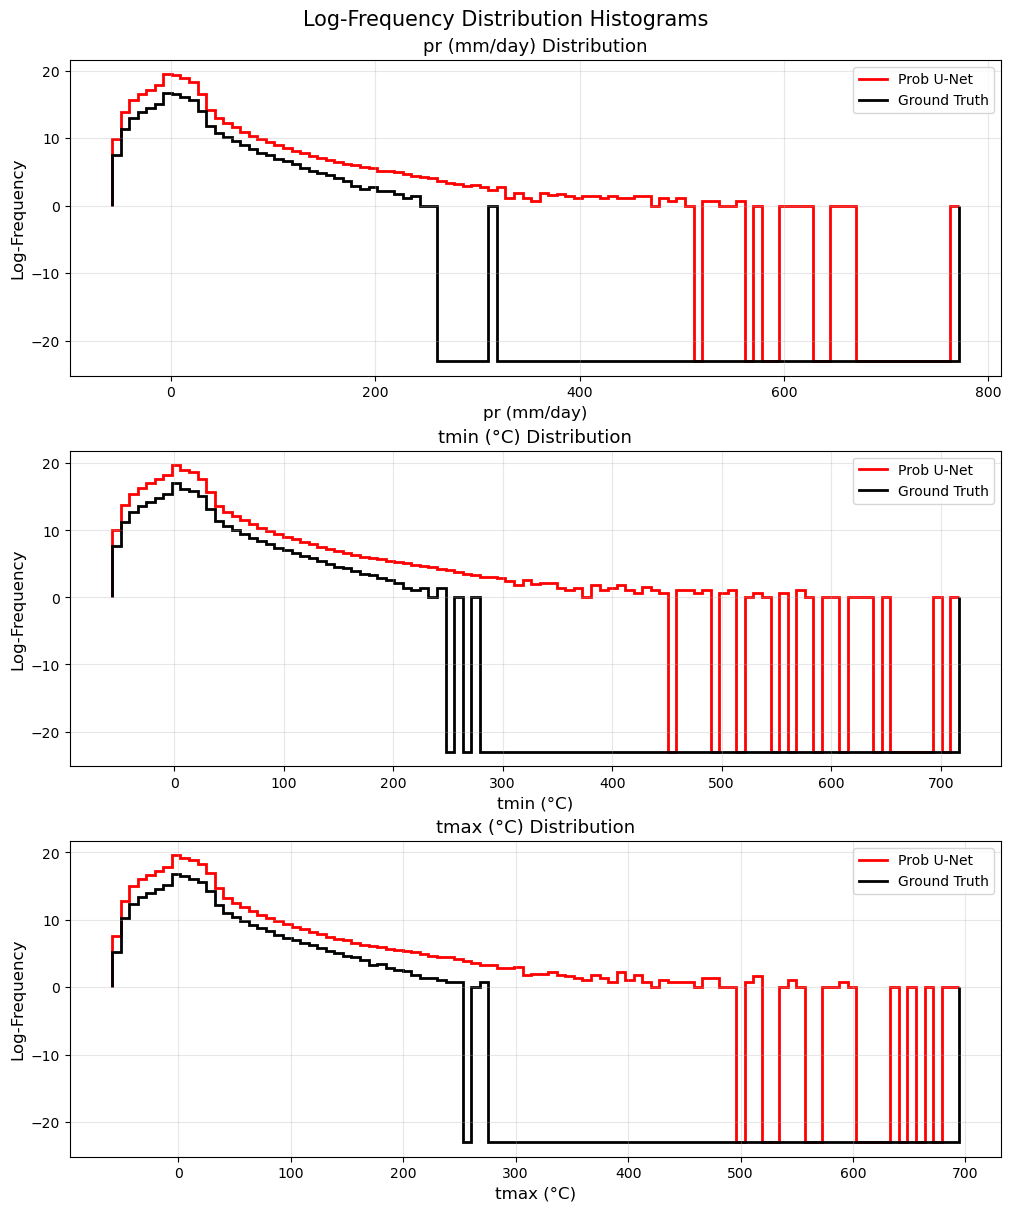

Plotting log-frequency distributions with ensemble members...


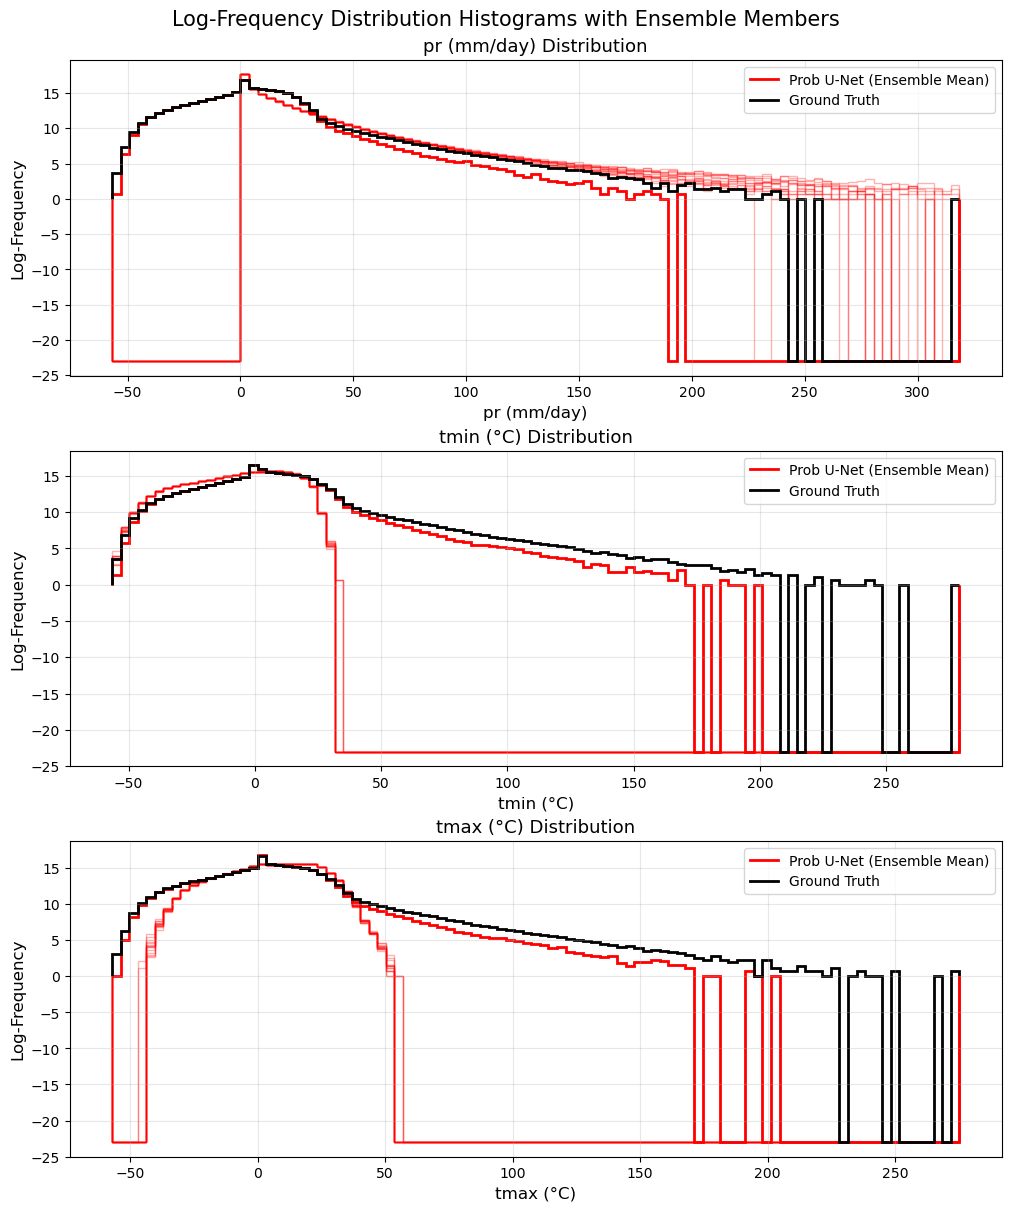

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_log_frequency_distributions(hr_real, preds_real, num_bins=100):
    """
    Plot log-frequency distribution histograms using stairs plot style
    
    Args:
        hr_real: torch.Tensor shape [T, 3, H, W] - ground truth in real domain
        preds_real: torch.Tensor shape [T, num_samples, 3, H, W] - predictions in real domain
        num_bins: number of histogram bins
    """
    # Convert to numpy and flatten all dimensions except variable dimension
    hr_np = hr_real.numpy()  # [T, 3, H, W]
    preds_np = preds_real.numpy()  # [T, num_samples, 3, H, W]
    
    # Flatten spatial and time dimensions
    hr_flat = hr_np.reshape(-1, 3)  # [T*H*W, 3]
    preds_flat = preds_np.reshape(-1, 3)  # [T*num_samples*H*W, 3]
    
    # Get min/max ranges for each variable
    pr_min, pr_max = min(hr_flat[:, 0].min(), preds_flat[:, 0].min()), max(hr_flat[:, 0].max(), preds_flat[:, 0].max())
    tmin_min, tmin_max = min(hr_flat[:, 1].min(), preds_flat[:, 1].min()), max(hr_flat[:, 1].max(), preds_flat[:, 1].max())
    tmax_min, tmax_max = min(hr_flat[:, 2].min(), preds_flat[:, 2].min()), max(hr_flat[:, 2].max(), preds_flat[:, 2].max())
    
    # Create ranges for histograms
    range_pr = np.linspace(pr_min, pr_max, num_bins)
    range_tmin = np.linspace(tmin_min, tmin_max, num_bins)
    range_tmax = np.linspace(tmax_min, tmax_max, num_bins)
    ranges = [range_pr, range_tmin, range_tmax]
    
    var_names = ["pr (mm/day)", "tmin (°C)", "tmax (°C)"]
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)
    
    for i, (range_vals, var_name) in enumerate(zip(ranges, var_names)):
        # Plot model predictions
        hist_pred = np.histogram(preds_flat[:, i], bins=range_vals)
        # Add small constant to avoid log(0)
        hist_pred_counts = hist_pred[0] + 1e-10
        axs[i].stairs(np.log(hist_pred_counts), hist_pred[1], 
                     label="Prob U-Net", color="red", linewidth=2)
        
        # Plot ground truth
        hist_gt = np.histogram(hr_flat[:, i], bins=range_vals)
        hist_gt_counts = hist_gt[0] + 1e-10
        axs[i].stairs(np.log(hist_gt_counts), hist_gt[1], 
                     label="Ground Truth", color="black", linewidth=2)
        
        axs[i].set_ylabel("Log-Frequency", fontsize=12)
        axs[i].set_xlabel(var_name, fontsize=12)
        axs[i].legend(fontsize=10)
        axs[i].grid(True, alpha=0.3)
        axs[i].set_title(f'{var_name} Distribution', fontsize=13)
    
    fig.suptitle("Log-Frequency Distribution Histograms", fontsize=15)
    plt.show()

# Alternative version with separate ensemble members shown
def plot_log_frequency_distributions_ensemble(hr_real, preds_real, num_bins=100):
    """
    Plot log-frequency distributions showing individual ensemble members
    """
    hr_np = hr_real.numpy()
    preds_np = preds_real.numpy()
    
    # Flatten spatial and time dimensions
    hr_flat = hr_np.reshape(-1, 3)  # [T*H*W, 3]
    
    # For predictions, we can either:
    # 1. Show all ensemble members combined (as above)
    # 2. Show ensemble mean
    # 3. Show individual ensemble members with transparency
    
    # Option 2: Ensemble mean
    preds_mean = preds_np.mean(axis=1)  # Average over ensemble dimension
    preds_mean_flat = preds_mean.reshape(-1, 3)  # [T*H*W, 3]
    
    # Get ranges
    pr_min, pr_max = min(hr_flat[:, 0].min(), preds_mean_flat[:, 0].min()), max(hr_flat[:, 0].max(), preds_mean_flat[:, 0].max())
    tmin_min, tmin_max = min(hr_flat[:, 1].min(), preds_mean_flat[:, 1].min()), max(hr_flat[:, 1].max(), preds_mean_flat[:, 1].max())
    tmax_min, tmax_max = min(hr_flat[:, 2].min(), preds_mean_flat[:, 2].min()), max(hr_flat[:, 2].max(), preds_mean_flat[:, 2].max())
    
    range_pr = np.linspace(pr_min, pr_max, num_bins)
    range_tmin = np.linspace(tmin_min, tmin_max, num_bins)
    range_tmax = np.linspace(tmax_min, tmax_max, num_bins)
    ranges = [range_pr, range_tmin, range_tmax]
    
    var_names = ["pr (mm/day)", "tmin (°C)", "tmax (°C)"]
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)
    
    for i, (range_vals, var_name) in enumerate(zip(ranges, var_names)):
        # Plot individual ensemble members with transparency
        for member in range(preds_np.shape[1]):
            member_data = preds_np[:, member, i, :, :].flatten()
            hist_member = np.histogram(member_data, bins=range_vals)
            hist_member_counts = hist_member[0] + 1e-10
            axs[i].stairs(np.log(hist_member_counts), hist_member[1], 
                         alpha=0.3, color="red", linewidth=1)
        
        # Plot ensemble mean
        hist_pred = np.histogram(preds_mean_flat[:, i], bins=range_vals)
        hist_pred_counts = hist_pred[0] + 1e-10
        axs[i].stairs(np.log(hist_pred_counts), hist_pred[1], 
                     label="Prob U-Net (Ensemble Mean)", color="red", linewidth=2)
        
        # Plot ground truth
        hist_gt = np.histogram(hr_flat[:, i], bins=range_vals)
        hist_gt_counts = hist_gt[0] + 1e-10
        axs[i].stairs(np.log(hist_gt_counts), hist_gt[1], 
                     label="Ground Truth", color="black", linewidth=2)
        
        axs[i].set_ylabel("Log-Frequency", fontsize=12)
        axs[i].set_xlabel(var_name, fontsize=12)
        axs[i].legend(fontsize=10)
        axs[i].grid(True, alpha=0.3)
        axs[i].set_title(f'{var_name} Distribution', fontsize=13)
    
    fig.suptitle("Log-Frequency Distribution Histograms with Ensemble Members", fontsize=15)
    plt.show()

# Plot the distributions
print("Plotting log-frequency distributions...")
plot_log_frequency_distributions(all_hr_real, all_preds_real, num_bins=100)

print("Plotting log-frequency distributions with ensemble members...")
plot_log_frequency_distributions_ensemble(all_hr_real, all_preds_real, num_bins=100)